In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read the data stored after pre-processing stage and analyze to ensure everthing looks fine

In [4]:
book_review_data = pd.read_csv("../data/interim/merged_data_ids.csv")

In [5]:
book_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360666 entries, 0 to 360665
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Title           360666 non-null  object 
 1   description     360666 non-null  object 
 2   authors         358299 non-null  object 
 3   categories      360666 non-null  object 
 4   User_id         360666 non-null  object 
 5   Ratings         360666 non-null  float64
 6   review/summary  360415 non-null  object 
 7   review/text     360666 non-null  object 
 8   UserId          360666 non-null  int64  
 9   BookId          360666 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 27.5+ MB


In [6]:
book_review_data.sort_values(by = 'UserId').head(10)

,Title,description,authors,categories,User_id,Ratings,review/summary,review/text,UserId,BookId
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...,0,0
305077,Artistic License: Three Centuries of Good Writ...,"""Ms. Allen goes on to show how the incendiarie...",Brooke Allen,"['Biography', 'Autobiography']",A30TK6U7DNS82R,3.0,the dentists office of literature,i hate these thrown together collections of es...,0,55023
105601,"Ahab's Wife: Or, the Star-Gazer","From the opening line—""Captain Ahab was neithe...",Sena Jeter Naslund,['Fiction'],A30TK6U7DNS82R,3.0,a good romance for the homebound,if you are a shutin who likes to keep one eye ...,0,15312
151308,Heart of the Matter,"""Giffin excels at creating complex characters ...",Emily Giffin,['Fiction'],A30TK6U7DNS82R,4.0,a matter of fact book that might save my life,i was lucky to stumble across an advance readi...,0,23995
269782,OUT OF THE SILENT PLANET - The Perelandra Tril...,Focuses on the age-old nature and consequences...,C.S. Lewis,['Fiction'],A30TK6U7DNS82R,5.0,should have been filmed instead of the narnia ...,it seems as though the success of the lord of ...,0,47659
244321,Who Wrote the Book of Love?,Een eeuwenoude tekst. Een bijzondere historisc...,Kathleen MacGowan,['Fiction'],A30TK6U7DNS82R,3.0,chuckles about sex,lee siegels novel of a group of sex obsessed b...,0,41974
359042,The Woman Who Walked to Russia: A Writer's Sea...,From the moment Pybus first heard about Lillia...,Cassandra Pybus,['Travel'],A30TK6U7DNS82R,3.0,easypeasy,cassandra pybus an australian writer heard abo...,0,66821
40133,Silent Spring,Rachel Carson's Silent Spring alerted a large ...,Rachel Carson,['Nature'],A30TK6U7DNS82R,5.0,another thoreau,rachel carson wrote so beautifully that any fe...,0,5686
49267,Ogden Nash: The Life and Work of America's Lau...,"Looks at the life, career, and writings of the...","Douglas M. Parker, Dana Gioia","['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,nashville,loved the book ogden nash not so much as a lit...,0,7233
270033,"New Spring - The Novel - The Wheel Of Time, In...",Moirain Damodred and Lan Mandragoran must find...,Robert Jordan,['Fiction'],A30TK6U7DNS82R,4.0,missing one kitchen sink,otherwise a new spring has everything that a r...,0,47695


In [7]:
book_review_data.sort_values(by="BookId").head(10)

,Title,description,authors,categories,User_id,Ratings,review/summary,review/text,UserId,BookId
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A30TK6U7DNS82R,5.0,really enjoyed it,i dont care much for dr seuss but after readin...,0,0
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2MVUWT453QH61,4.0,phlip nel gives silly seuss a serious treatment,theodore seuss geisel 19041991 aka quotdr seus...,1,0
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,"['Biography', 'Autobiography']",A2F6NONFUDB6UK,4.0,one of americas greatest creative talents,dr seuss american icon by philip nel is a thou...,2,0
3,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,['Religion'],A373VVEU6Z9M0N,5.0,small churches can have wonderful worship,many small churches feel like they can not hav...,3,1
4,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,Steven Wardell,['Social Science'],A3NIQK6ZLYEP1L,4.0,almost a day by day view,steven wardell went to japan without reading a...,4,2
5,Muslim Women's Choices: Religious Belief and S...,Counters the Western views and stereotypes of ...,"Camillia Fawzi El-Solh, Judy Mabro",['Religion'],ATDE9JYCPI0L1,2.0,oh dear,i was excited to find a book ostensibly about ...,5,3
6,Dramatica for Screenwriters,Dramatica for Screenwriters by Armando Saldana...,Armando Salda A-Mora,['Reference'],A32ZQ5DEXBL60Z,5.0,even as a fiction writer i found this book inv...,i think the hardest thing for people coming to...,6,4
7,Vector Quantization and Signal Compression (Th...,"Herb Caen, a popular columnist for the San Fra...","Allen Gersho, Robert M. Gray","['Technology', 'Engineering']",A29Z0B2L367ZO,5.0,great reference book for its topic,it seems somebody was complaining for the prin...,7,5
10,Eyewitness Travel Guide to Europe,The DK Eyewitness Travel Guide: Eastern and Ce...,"Dorling Kindersley Publishing Staff, Jonathan ...",['Europe'],AT9YSY20RJUDX,4.0,helpful guide on tours through europe,i recently took a backpack trip through europe...,10,6
8,Eyewitness Travel Guide to Europe,The DK Eyewitness Travel Guide: Eastern and Ce...,"Dorling Kindersley Publishing Staff, Jonathan ...",['Europe'],A281NPSIMI1C2R,5.0,the major sights in twenty countries amazing,yes this is one heavy book it is more than lik...,8,6


### We will start building the collaborative filtering model

In [8]:
X = book_review_data[['UserId', 'BookId']]
y = book_review_data[['Ratings']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = .25, random_state = 0, stratify = book_review_data.Ratings.values)

### We will use PyTorch to build our collaborative filtering model. The first step in build a PyTorch model is to define the dataset

In [9]:
class BookReviewDataset(Dataset):
    def __init__(self, users, books, ratings):
        self.users = users
        self.books = books
        self.ratings = ratings
    
    # length will be all the reviews, which we can get using length of users
    def __len__(self):
        return len(self.users)
     
    def __getitem__(self, idx):

        users = self.users[idx] 
        books = self.books[idx]
        ratings = self.ratings[idx]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "books": torch.tensor(books, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

In [10]:
train_dataset = BookReviewDataset(
    users=X_train.UserId.values,
    books=X_train.BookId.values,
    ratings=y_train.Ratings.values
)

valid_dataset = BookReviewDataset(
    users=X_test.UserId.values,
    books=X_test.BookId.values,
    ratings=y_test.Ratings.values
)

### We will now build DataLoaders and do a manual iteration to check if it works fine

In [11]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True) 

dataiter = iter(train_loader)
dataloader_data = next(dataiter) 
print(dataloader_data)

{'users': tensor([14583, 12710,   302, 14527]), 'books': tensor([43948, 19552, 23974, 22738]), 'ratings': tensor([4, 3, 5, 5])}


### We now build the model. The model is based on the collaborative filtering based on matrix factorization. The model creates embeddings for users and books. It then uses the product of user and web embedding to calculate the ratings. The model eventually uses Stochastic gradient decent to optimize the embedding so that the difference between predicted rating (obtained by embedding multiplication) and actual rating is minimal. The sigmoid function is used for the output to ensure the rating is between 0 and 5

In [12]:
class BookRecModel(nn.Module):
    def __init__(self, n_users, n_books, n_factors = 50, y_range=(0,5.5)):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embeds = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_embeds = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.y_range = y_range
        
    def forward(self, users, books, ratings=None):
        user_factors = self.user_embeds(users)
        book_factors = self.book_embeds(books)
        res = (user_factors * book_factors).sum(dim = 1, keepdim = True)
        res += self.user_bias (users) + self.book_bias(books)
        return torch.sigmoid(res) * 5.5

In [13]:
unique_users = X.UserId.unique().shape[0]
unique_books = X.BookId.unique().shape[0]
print (unique_users, unique_books)

21147 67192


### Here set the optimizer, learning rate and weight decay. It took a few iterations to find the most optimal values

In [14]:
model = BookRecModel (n_users = unique_users, n_books = unique_books).to(device)
optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.5) #torch.optim.Adam(model.parameters(), weight_decay=0.1)  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_func = nn.MSELoss()

### Now we train the model. We will be just running one epoch

In [15]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    step_cnt = 0
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["books"].to(device)
                      ) 
        
        rating = train_data["ratings"].view(output.size()[0], -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss


epoch 0 loss at step: 5000 is 0.24357187252789736
epoch 0 loss at step: 10000 is 0.2020240258064121
epoch 0 loss at step: 15000 is 0.19991906626448036
epoch 0 loss at step: 20000 is 0.199828506334126
epoch 0 loss at step: 25000 is 0.2021632206186652
epoch 0 loss at step: 30000 is 0.20141556344479322
epoch 0 loss at step: 35000 is 0.2010456224180758
epoch 0 loss at step: 40000 is 0.1998388542741537
epoch 0 loss at step: 45000 is 0.20180967107862235
epoch 0 loss at step: 50000 is 0.2005848926976323
epoch 0 loss at step: 55000 is 0.20007767412513494
epoch 0 loss at step: 60000 is 0.19878186824377625
epoch 0 loss at step: 65000 is 0.20334235767796635
epoch 0 loss at step: 70000 is 0.20246565698087216
epoch 0 loss at step: 75000 is 0.2019658163074404
epoch 0 loss at step: 80000 is 0.20120332323610782
epoch 0 loss at step: 85000 is 0.20098521508425474
epoch 0 loss at step: 90000 is 0.19976731309443713
epoch 0 loss at step: 95000 is 0.20290634814724326
epoch 0 loss at step: 100000 is 0.199444

### Here is the graph on how the loss changed for each batch of training

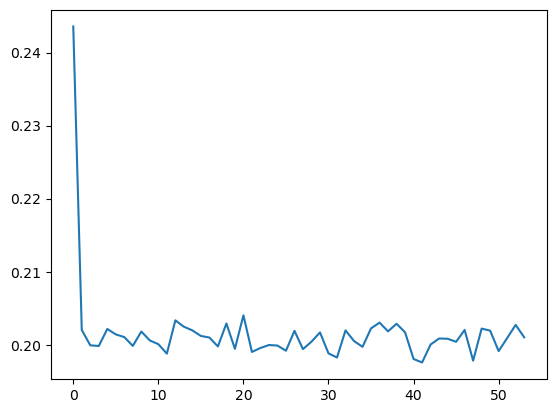

In [16]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

### Let's now evaluate the model using validation (test in this case) dataset. 

In [50]:
model.eval()
y_pred = []
y_actual = []    
    
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["books"].to(device))
        
        # Convert model ouput to numpy array
        numparray = model_output.squeeze().detach().cpu().numpy()
        y_pred.extend(numparray)
        y_actual.extend(batched_data['ratings'].detach().cpu().numpy().tolist())
        #print (f"Model output {model_output} actual ratings {batched_data['ratings']}" )



### Let's calculate the MSE now. We will use the actual predicted values from the model to calculate MSE

In [19]:
from sklearn.metrics import mean_squared_error
print (f"MSE is {mean_squared_error(y_pred, y_actual)} ")

MSE is 3.212548535817936 


### MSE is high but for us the most important is to ensure that the embeddings from the models can be used to make predictions. We will now explore book embedding and book bias embedding

### As the first step, we will check book bias embedding. Book bias means the weight a book recieves irrespective of the user input. Thus a high value of book bias means that the book is generally liked by users and vice versa

In [51]:
model

BookRecModel(
  (user_embeds): Embedding(21147, 50)
  (user_bias): Embedding(21147, 1)
  (book_embeds): Embedding(67192, 50)
  (book_bias): Embedding(67192, 1)
)

In [21]:
book_bias = model.book_bias.weight.squeeze()

In [22]:
pd.DataFrame(book_bias.detach().cpu().numpy()).describe()

,0
count,6.719200e+04
mean,1.197248e-04
std,1.114866e-03
min,-1.067394e-02
25%,1.261169e-43
50%,1.261169e-43
75%,1.218287e-25
max,4.346438e-02


#### We will first build a map between books ids and book details

In [ ]:
bookId_Map = book_review_data.groupby(by='BookId')[['Title', 'description', 'categories', 'Ratings']].agg({'Title': pd.Series.mode, 'description':pd.Series.mode, 'categories': pd.Series.mode, 'Ratings': pd.Series.mean })

In [24]:
bookId_Map.head(10)

,Title,description,categories,Ratings
BookId,,,,
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,"['Biography', 'Autobiography']",4.333333
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['Religion'],5.000000
2,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,['Social Science'],4.000000
3,Muslim Women's Choices: Religious Belief and S...,Counters the Western views and stereotypes of ...,['Religion'],2.000000
4,Dramatica for Screenwriters,Dramatica for Screenwriters by Armando Saldana...,['Reference'],5.000000
5,Vector Quantization and Signal Compression (Th...,"Herb Caen, a popular columnist for the San Fra...","['Technology', 'Engineering']",5.000000
6,Eyewitness Travel Guide to Europe,The DK Eyewitness Travel Guide: Eastern and Ce...,['Europe'],4.666667
7,History of Magic and the Occult,"See the history of witchcraft, magic and super...","['Body, Mind', 'Spirit']",5.000000
8,Voices from the Farm: Adventures in Community ...,"Twenty-five years ago, at the height of the co...","['Biography', 'Autobiography']",5.000000


#### We will now print books with the highest biases

In [25]:
idxs = book_bias.argsort(descending=True)[:5]
[bookId_Map.Title [i] for i in idxs.detach().cpu().numpy()]

['Pride and Prejudice',
 'Little Women',
 'The Hobbitt, or there and back again; illustrated by the author.',
 'The Hobbit',
 'The Hobbit There and Back Again']

#### All 5 books are highly rated 

### Let's see what bottom 5 books are irrespective of user rating

In [26]:
idxs = book_bias.argsort(descending=False)[:5]
[bookId_Map.Title [i] for i in idxs.detach().cpu().numpy()]

["That's Just Your Interpretation: Responding to Skeptics Who Challenge Your Faith",
 'Death comes for the Archbishop',
 'A SONG OF STONE: A Novel',
 'The real world of democracy, (The Massey lectures)',
 'The Stone Diaries']

#### According to the model, these are the books people generally don't like

### We will now explore book embedding data. Books with similar embeddings should be similar. We will do K-means analysis to cluster similar books using book embeddings

In [27]:
book_embedding = model.book_embeds.weight.squeeze().detach().cpu().numpy()

In [28]:
bem_df = pd.DataFrame(book_embedding)

In [29]:
bem_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.261169e-43,-1.219130e-43,1.205117e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.219130e-43,-1.191104e-43,1.191104e-43,-1.233143e-43,...,1.205117e-43,1.261169e-43,1.261169e-43,-1.219130e-43,-1.205117e-43,1.233143e-43,-1.219130e-43,1.261169e-43,1.205117e-43,-1.205117e-43
1,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,...,1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43
2,1.219130e-43,1.261169e-43,-1.233143e-43,-1.233143e-43,-1.219130e-43,-1.261169e-43,-1.219130e-43,-1.219130e-43,-1.219130e-43,-1.233143e-43,...,-1.261169e-43,-1.261169e-43,-1.219130e-43,-1.261169e-43,1.261169e-43,1.261169e-43,-1.219130e-43,1.261169e-43,-1.233143e-43,-1.219130e-43
3,1.261169e-43,1.261169e-43,1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,...,-1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43
4,1.149065e-43,1.149065e-43,1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,-1.149065e-43,-1.149065e-43,1.261169e-43,-1.149065e-43,...,1.149065e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,-1.149065e-43,-1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67187,-1.177091e-43,-1.261169e-43,1.163078e-43,-1.261169e-43,1.177091e-43,-1.177091e-43,1.261169e-43,1.177091e-43,1.261169e-43,1.163078e-43,...,-1.163078e-43,-1.261169e-43,1.163078e-43,1.261169e-43,-1.261169e-43,1.261169e-43,-1.163078e-43,1.163078e-43,1.261169e-43,-1.261169e-43
67188,-1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,1.261169e-43,...,1.261169e-43,1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43
67189,-1.261169e-43,-1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,1.261169e-43,...,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,1.261169e-43,-1.261169e-43,1.261169e-43,1.261169e-43
67190,1.261169e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,-1.163078e-43,-1.261169e-43,-1.163078e-43,-1.261169e-43,1.149065e-43,-1.261169e-43,...,-1.261169e-43,1.163078e-43,1.149065e-43,1.149065e-43,1.261169e-43,-1.261169e-43,-1.261169e-43,-1.149065e-43,1.261169e-43,1.163078e-43


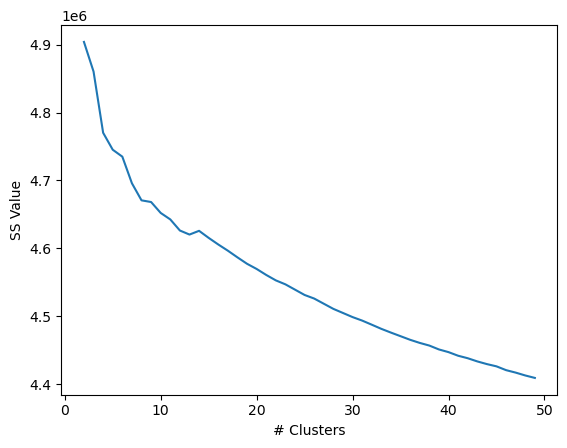

In [36]:
from sklearn.cluster import KMeans
import sklearn

SS_values = []
kk_values = range (2,50)

for num_clusters in kk_values:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(bem_df*1e43) # we are multiplying by 1e43
    SS_values.append(kmeans.inertia_)
    
ax = sns.lineplot(y=SS_values, x = kk_values);
ax.set(xlabel="# Clusters", ylabel = 'SS Value');

### We will select optimal value as 12 and perform the clustering again

In [37]:
num_clusters = 12

In [38]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(bem_df*1e43)
kmeans.labels_

array([3, 7, 2, ..., 6, 1, 1])

In [39]:
book_cluster = bookId_Map.assign(cluster_num = kmeans.labels_)

In [40]:
book_cluster.head(5)

,Title,description,categories,Ratings,cluster_num
BookId,,,,,
0,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,"['Biography', 'Autobiography']",4.333333,3
1,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['Religion'],5.000000,7
2,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,['Social Science'],4.000000,2
3,Muslim Women's Choices: Religious Belief and S...,Counters the Western views and stereotypes of ...,['Religion'],2.000000,10
4,Dramatica for Screenwriters,Dramatica for Screenwriters by Armando Saldana...,['Reference'],5.000000,7


### Now we will use HuggingFace model to analyze the book personality based on the cluster assigned. The steps we will follow are as follows:

- Put together all the text from books in the same cluster
- Get personality of the cluster using HuggingFace library - https://huggingface.co/Minej/bert-base-personality
- Ask user to enter text to assess their personality
- Based on user personality identify the closest cluster by using cosine distance between personailty values
- Recommend top 5 books in the cluster that closely matches the user personality

#### Here is the function for getting user personality type using Hugging Face model

In [41]:
from transformers import BertTokenizer, BertForSequenceClassification

def personality_detection(text):
    tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
    model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().detach().numpy()

    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result

#### Club text of the books in the same cluster together

In [42]:
cluster_text = []
for i in range (num_clusters):
    cluster_text.append(book_cluster[book_cluster.cluster_num == i].description.sum())


#### Get personality type from cluster text

In [43]:
cluster_personality_result = []
for x in range(len(cluster_text)):
    cluster_personality_result.append(personality_detection(cluster_text[x]))

#### Analyze the results

In [44]:
cluster_analysis_df = pd.DataFrame(cluster_personality_result)
cluster_analysis_df

,Extroversion,Neuroticism,Agreeableness,Conscientiousness,Openness
0,-0.173596,0.077235,0.286539,-0.023153,0.277903
1,-0.180531,0.117402,0.223222,0.224351,0.240000
2,-0.425786,0.132827,0.258109,-0.240793,-0.039392
3,-0.140911,0.058348,0.229398,-0.372537,0.095843
4,-0.121187,0.223386,0.184633,-0.250837,0.142971
5,-0.151138,0.130494,0.266657,-0.144430,0.139426
6,-0.045484,0.023177,0.181009,0.030891,0.473379
7,-0.010821,0.055742,0.117074,-0.383787,0.175144
8,-0.041048,0.285837,-0.013113,-0.293762,0.328356
9,0.074150,0.212719,0.129479,-0.127371,0.419017


#### We will build a function to get book recommendations based on personality type

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
def getTop5BooksFromBio(text):
    print ("------------- Analysis Starts ------------")
    result = personality_detection(bio) #Get the personality value
    print (f"Your personality result {result}")
    dist = cosine_similarity(cluster_analysis_df, pd.DataFrame(result, index=[0])) #Calculate cosine similarity
    dist = np.absolute(dist)
    min_index = dist.argmin()
    print (f"Cosine distances between your personality and books personality are {dist} and the min index is {min_index}")
    print ("-------------  Analysis Ends ------------")
    
    #Get top 5 books from the cluster
    print ("")
    print ("-------------  Top 5 Books  ------------")
    print(book_cluster[book_cluster.cluster_num == min_index].sort_values(by="Ratings", ascending=False)[['Title']][0:5].to_string(index=False))
    
    

### A couple of example runs

#### Example 1

In [46]:
print ("Please share 3 - 4 lines about yourself")
bio = input()

Please share 3 - 4 lines about yourself
I like spending time alone and love to go into the nature. I love hiking and I practice yoga and meditation often


In [47]:
getTop5BooksFromBio (bio)

------------- Analysis Starts ------------
Your personality result {'Extroversion': 0.15667897, 'Neuroticism': 0.18387038, 'Agreeableness': -0.05196483, 'Conscientiousness': -0.48914763, 'Openness': 0.014780233}
Cosine distances between your personality and books personality are [[0.05132121]
 [0.5026083 ]
 [0.19675264]
 [0.61829454]
 [0.587009  ]
 [0.27747837]
 [0.07286479]
 [0.79656714]
 [0.6762401 ]
 [0.40297988]
 [0.75599277]
 [0.67744535]] and the min index is 0
-------------  Analysis Ends ------------

-------------  Top 5 Books  ------------
                                                                                                             Title
Vector Quantization and Signal Compression (The Springer International Series in Engineering and Computer Science)
                                                                          Not Ashamed: The Story of Jews for Jesus
                                                The Great Wall and the Empty Fortress: China's Sear

#### Example 2

In [48]:
print ("Please share 3 - 4 lines about yourself")
bio = input()

Please share 3 - 4 lines about yourself
I like to party. Meeting people and making new friends gives me energy.


In [49]:
getTop5BooksFromBio (bio)

------------- Analysis Starts ------------
Your personality result {'Extroversion': -0.05585039, 'Neuroticism': 0.06573107, 'Agreeableness': 0.037323017, 'Conscientiousness': -0.23692867, 'Openness': -0.10651664}
Cosine distances between your personality and books personality are [[0.01104617]
 [0.42133483]
 [0.65641785]
 [0.7522643 ]
 [0.6154939 ]
 [0.4312832 ]
 [0.33284745]
 [0.6634509 ]
 [0.37931606]
 [0.00155666]
 [0.2993672 ]
 [0.31514388]] and the min index is 9
-------------  Analysis Ends ------------

-------------  Top 5 Books  ------------
                                                                                                                                                       Title
                                                                                                                             History of Magic and the Occult
Your Disgusting Head: The Darkest, Most Offensive and Moist Secrets of Your Ears, Mouth and Nose (How Books: Haggis-On-Whey World

### We finally have a book recommendation model based on user personality type. Definitely, the model needs many improvements.